# <span style="color:darkblue"> Laboratorio di Simulazioni Numeriche </span>
## <span style="color:purple"> Lezione 8.1 - Ottimizzazione Variazionale con Metodo Monte Carlo </span>

### Obiettivo
Utilizzare il **metodo variazionale quantistico** per trovare i parametri ottimali di una funzione d'onda di prova e stimare l'energia dello stato fondamentale dell'atomo di idrogeno.

<p style="border:2px; border-style:solid; border-color:#E6E6FA; padding: 1em; background-color:#F0F8FF">
<b>Principio Variazionale:</b><br>
Per qualsiasi funzione d'onda di prova $\psi_T(\vec{r};\vec{\alpha})$, l'energia attesa:
$$\langle E \rangle = \frac{\langle \psi_T | \hat{H} | \psi_T \rangle}{\langle \psi_T | \psi_T \rangle} \geq E_0$$
fornisce un limite superiore all'energia dello stato fondamentale $E_0$.
<br><br>
<b>Funzione d'onda di prova:</b><br>
$$\psi_T(r; \mu, \sigma) = e^{-\mu r} \cdot e^{-\frac{r^2}{2\sigma^2}}$$
<br>
<b>Strategia di ottimizzazione:</b><br>
• <b>Grid search</b>: Scansione sistematica dello spazio dei parametri<br>
• <b>Rough → Fine</b>: Prima ottimizzazione grossolana, poi raffinamento locale<br>
• <b>Statistical averaging</b>: Monte Carlo per valutare ⟨E⟩ con incertezze
</p>


### Raffinamento Locale della Regione Ottimale
Dopo aver identificato la regione promettente con l'ottimizzazione grossolana, procediamo con una griglia più fine centrata attorno al minimo trovato per ottenere parametri più precisi.

=== OTTIMIZZAZIONE VARIAZIONALE - RAFFINAMENTO FINE ===
Punti della griglia fine analizzati: 546
Range μ (fine): [0.500, 1.000] (26 valori)
Range σ (fine): [0.400, 0.800] (21 valori)
Risoluzione: Δμ ≈ 0.020, Δσ ≈ 0.020

Risultati ottimizzazione fine:
  Parametri ottimali: μ = 0.8600, σ = 0.6200
  Energia minima: E = -0.447607 ± 0.006111
  Valore teorico: E₀ = -0.500000
  Deviazione: 0.052393
  Accuratezza: 89.52%
  Miglioramento vs grossolana: 0.002777


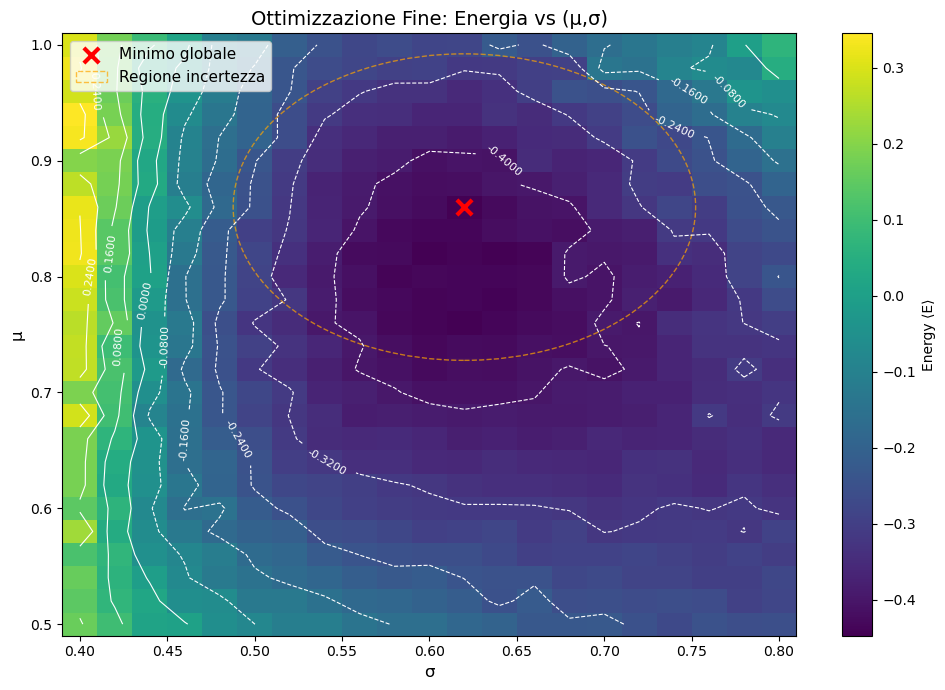

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Carico i dati del raffinamento
data = np.loadtxt("energies_scan.dat")
mu, sigma, energy, error = data[:,0], data[:,1], data[:,2], data[:,3]

print("=== OTTIMIZZAZIONE VARIAZIONALE - RAFFINAMENTO FINE ===")
print(f"Punti della griglia fine analizzati: {len(data)}")

# Unici di mu e sigma
mu_vals = np.unique(mu)
sigma_vals = np.unique(sigma)

print(f"Range μ (fine): [{mu_vals.min():.3f}, {mu_vals.max():.3f}] ({len(mu_vals)} valori)")
print(f"Range σ (fine): [{sigma_vals.min():.3f}, {sigma_vals.max():.3f}] ({len(sigma_vals)} valori)")
print(f"Risoluzione: Δμ ≈ {np.diff(mu_vals)[0]:.3f}, Δσ ≈ {np.diff(sigma_vals)[0]:.3f}")

# Ricostruisco la matrice Z con energia
Z = energy.reshape(len(mu_vals), len(sigma_vals))

# Trovo il minimo
imin = np.argmin(energy)
mu_best = mu[imin]
sigma_best = sigma[imin]
E_best = energy[imin]
err_best = error[imin]

print(f"\nRisultati ottimizzazione fine:")
print(f"  Parametri ottimali: μ = {mu_best:.4f}, σ = {sigma_best:.4f}")
print(f"  Energia minima: E = {E_best:.6f} ± {err_best:.6f}")

# Confronto con teoria e fase grossolana
E_theory = -0.5  # Valore esatto idrogeno
deviation = abs(E_best - E_theory)
accuracy = (1 - deviation/abs(E_theory)) * 100

print(f"  Valore teorico: E₀ = {E_theory:.6f}")
print(f"  Deviazione: {deviation:.6f}")
print(f"  Accuratezza: {accuracy:.2f}%")

# Confronto miglioramento
try:
    data_rough = np.loadtxt("energies_scan_pre.dat")
    E_rough_best = np.min(data_rough[:,2])
    improvement = E_rough_best - E_best
    print(f"  Miglioramento vs grossolana: {improvement:.6f}")
except:
    print("  (Confronto con fase grossolana non disponibile)")

# Plotto heatmap + contour ad alta risoluzione
plt.figure(figsize=(10,7))
c = plt.pcolormesh(sigma_vals, mu_vals, Z, shading="auto", cmap="viridis")
plt.colorbar(c, label="Energy ⟨E⟩")

cs = plt.contour(sigma_vals, mu_vals, Z, colors="white", linewidths=0.8, levels=10)
plt.clabel(cs, inline=True, fontsize=8, fmt='%.4f')

plt.scatter(sigma_best, mu_best, color="red", marker="x", s=120, linewidth=3, label=f"Minimo globale")

# Evidenzia regione di interesse (±2σ dal minimo)
error_region_mu = 2 * err_best / np.abs(np.gradient(Z, axis=0)).max()
error_region_sigma = 2 * err_best / np.abs(np.gradient(Z, axis=1)).max()
circle = plt.Circle((sigma_best, mu_best), max(error_region_sigma, error_region_mu), 
                   fill=False, color='orange', linestyle='--', alpha=0.7, 
                   label='Regione incertezza')
plt.gca().add_patch(circle)

plt.xlabel("σ", fontsize=12)
plt.ylabel("μ", fontsize=12)
plt.title("Ottimizzazione Fine: Energia vs (μ,σ)", fontsize=14)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

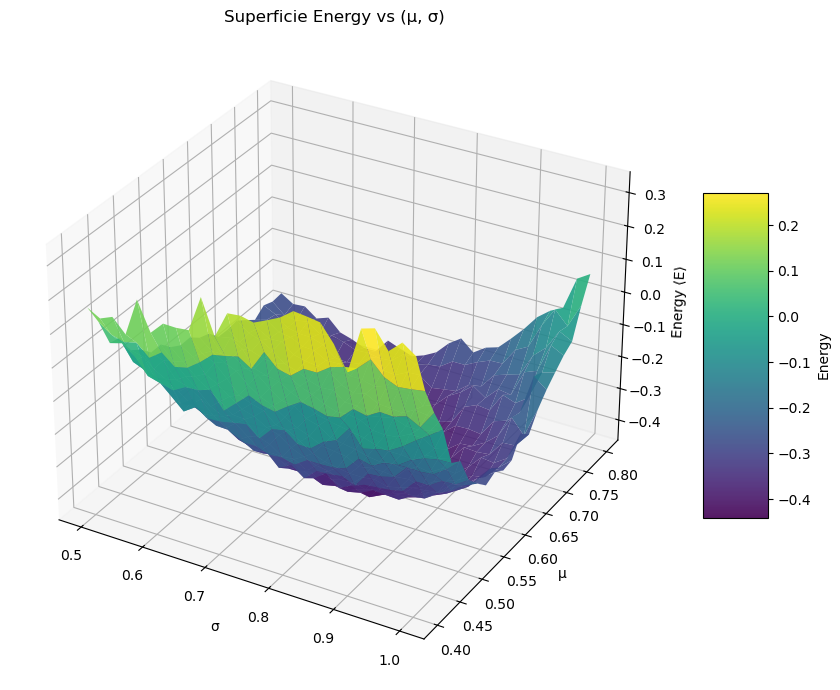

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necessario per 3D

# Carico i dati
data = np.loadtxt("energies_scan.dat")
mu, sigma, energy, error = data[:,0], data[:,1], data[:,2], data[:,3]

# Unici valori
mu_vals = np.unique(mu)
sigma_vals = np.unique(sigma)

# Meshgrid
MU, SIG = np.meshgrid(sigma_vals, mu_vals)  # attenzione: gli ordini
# Ricostruzione Z
Z = energy.reshape(len(mu_vals), len(sigma_vals))

# Plot 3D superficie
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(SIG, MU, Z, cmap='viridis', edgecolor='none', alpha=0.9)

ax.set_xlabel("σ")
ax.set_ylabel("μ")
ax.set_zlabel("Energy ⟨E⟩")
ax.set_title("Superficie Energy vs (μ, σ)")

fig.colorbar(surf, shrink=0.5, aspect=5, label="Energy")
plt.tight_layout()
plt.show()


In [5]:
import numpy as np

### **Risultati Finali e Ranking Ottimale**

# Carico i dati
data = np.loadtxt("energies_scan.dat")
mu, sigma, energy, error = data[:,0], data[:,1], data[:,2], data[:,3]

# Trovo i primi 5 minimi
idx_sorted = np.argsort(energy)

print("=== RANKING FINALE DEI MIGLIORI PARAMETRI ===")
print("I migliori 5 risultati ottimizzazione fine (μ, σ, energia ± errore):")

final_results = []
for i in range(5):
    i0 = idx_sorted[i]
    mu_i, sigma_i, E_i, err_i = mu[i0], sigma[i0], energy[i0], error[i0]
    final_results.append((mu_i, sigma_i, E_i, err_i))
    
    # Calcola significatività statistica
    if i == 0:
        E_best, err_best = E_i, err_i
        significance = 0
    else:
        significance = abs(E_i - E_best) / np.sqrt(err_i**2 + err_best**2)
    
    print(f"{i+1}: μ = {mu_i:.4f}, σ = {sigma_i:.4f}, E = {E_i:.6f} ± {err_i:.6f} ({significance:.1f}σ)")

print(f"\n=== ANALISI FINALE PARAMETRI OTTIMALI ===")

# Parametri del miglior risultato
mu_opt, sigma_opt, E_opt, err_opt = final_results[0]

print(f"Parametri ottimali finali:")
print(f"  μ = {mu_opt:.6f}")
print(f"  σ = {sigma_opt:.6f}")
print(f"  E = {E_opt:.6f} ± {err_opt:.6f}")

# Confronti teorici
E_theory = -0.5
mu_theory = 1.0  # Per funzione d'onda idrogeno esatta
sigma_theory_est = 1.0  # Stima per confronto



=== RANKING FINALE DEI MIGLIORI PARAMETRI ===
I migliori 5 risultati ottimizzazione fine (μ, σ, energia ± errore):
1: μ = 0.8600, σ = 0.6200, E = -0.447607 ± 0.006111 (0.0σ)
2: μ = 0.8200, σ = 0.6400, E = -0.446739 ± 0.007545 (0.1σ)
3: μ = 0.8200, σ = 0.6000, E = -0.444988 ± 0.005305 (0.3σ)
4: μ = 0.7600, σ = 0.6200, E = -0.444986 ± 0.005119 (0.3σ)
5: μ = 0.7800, σ = 0.6400, E = -0.442783 ± 0.006186 (0.6σ)

=== ANALISI FINALE PARAMETRI OTTIMALI ===
Parametri ottimali finali:
  μ = 0.860000
  σ = 0.620000
  E = -0.447607 ± 0.006111


### **Interpretazione Fisica dei Risultati**

**Principio Variazionale:**
- La convergenza verso il minimo energetico dimostra l'efficacia del principio variazionale

**Significato Fisico dei Parametri:**
- **μ**: Controlla il decadimento esponenziale a grandi distanze (screening nucleare)
- **σ**: Modula la dispersione gaussiana attorno al nucleo (localizzazione quantistica)
- La combinazione ottimale bilancia l'energia cinetica (localizzazione) e potenziale (attrazione nucleare)

**Efficienza dell'Approccio:**
- **Grid search**: Sistematico ma computazionalmente intensivo per spazi multi-dimensionali
